# Bias Buccaneers Image Recognition Challenge: Quickstart

This notebook will introduce you to the data and describe a workflow to train and evaluate a baseline model on it.

## Initial Setup

We start with loading the required packages.

In [1]:
# !pip install tensorflow
import numpy as np
import pandas as pd
import json
import logging
import os
from pathlib import Path
from functools import lru_cache

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import cv2

import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50

logger = logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

## Load the Data

Make sure to download and uncompress the data (`data_bb1_img_recognition.zip`) in the folder you're working off of.

We first load the file containing the labels, binarize labels of each of the three classes as a numpy array and store them as a list.

In [3]:

@lru_cache(maxsize=1000)
def load_rgb(path: Path, rgb=False) -> np.ndarray:
    img = cv2.imread(str(path))
    if not rgb:
        return img
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def show_img(img):
    cv2.imshow('image',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def resize_img(img, width: int=64, height: int=64):
    return cv2.resize(img, (width, height))

In [2]:
# load data
LOADPATH = Path("../Downloads/data_bb1/train/")
assert LOADPATH.exists()
SAVEPATH = './models/'
df = pd.read_csv( "train/labels.csv")
aug_df = pd.read_csv(LOADPATH / "intersect_augment.csv")
new_aug = aug_df[["aug_name", "skin_tone", "gender", "age"]].rename({"aug_name": "name"}, axis=1)
df_labeled = pd.concat([df.loc[df["real_face"] == 1, ["name", "skin_tone", "gender", "age"]], new_aug], axis=0).dropna().reset_index(drop=True)
age_counts = df_labeled["age"].value_counts()
# downsample to min class
min_class = age_counts.min()
df_labeled = df_labeled.groupby("age").apply(lambda x: x.sample(min_class)).reset_index(drop=True)

# Converting labels to np array
cat = ['skin_tone','gender','age']
lbs = [LabelBinarizer() for i in range(3)]
Y = []
for i in range(3):
    lab = lbs[i].fit_transform(df_labeled[cat[i]])
    if lab.shape[1]==1:
        Y.append(np.hstack((1-lab,lab)))
    else:
        Y.append(lab)

In [10]:
df[df["real_face"] == 1].dropna().shape

(3064, 5)

In [8]:
def great_load(path):
    return resize_img(load_rgb(path, rgb=True))

In [9]:

# loading and converting data into np array
print("Loading images")
length = width = 64 # size for each input image, increase if you want
nn = df_labeled.shape[0]
all_imgs = [great_load(LOADPATH / df_labeled['name'][i]) for i in range(nn)]
#all_imgs = [image.load_img(LOADPATH/df_labeled.iloc[i]['name'], target_size=(length,width)) for i in range(nn)]

print("Converting images to np array")
X = np.empty([nn, length, width, 3], dtype=float)
for i in range(nn):
    X[i,:] = image.img_to_array(all_imgs[i])
X = K.applications.resnet50.preprocess_input(X)

Loading images
Converting images to np array


We then load the images under the training set and convert them to numpy arrays. This may take a while.

In [75]:
@lru_cache(maxsize=1000)
def load_rgb(path: Path, rgb=False) -> np.ndarray:
    img = cv2.imread(str(path))
    if not rgb:
        return img
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def show_img(img):
    cv2.imshow('image',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

testimg = load_rgb(LOADPATH / df_labeled.loc[1, "name"])

show_img(testimg)

## Specify the Model

We define a single model class that is able train on the data in `X` and `Y` and predict outcomes for all three classes.

In [10]:
class PredictionModel():
    def __init__(self, X, Y, idx):
        self.X = X
        self.Y = Y
        self.idx = idx
        self.trainX, self.testX = X[idx[0],:], X[idx[1],:]
        self.trainY, self.testY = [Y[i][idx[0],:] for i in range(3)], [Y[i][idx[1],:] for i in range(3)]
        self.cat = ['skin_tone','gender','age']
        self.loss = ['categorical_crossentropy' for i in range(3)]
        self.metrics = [['accuracy'] for i in range(3)]
        self.models = [None]*3

    # train a model specific for a certain class index in self.cat
    def fit(self, index, model, epochs=5, batch_size=32, save=False, save_location=None, verbose=1):
        
        if verbose: print("Training model for "+self.cat[index])
        model.add(K.layers.Dense(self.trainY[index].shape[1], activation='softmax'))
        model.compile(loss=self.loss[index], optimizer='Adam', metrics=self.metrics[index])
        model.fit(
            self.trainX, self.trainY[index], 
            validation_data=(self.testX,self.testY[index]), 
            batch_size=batch_size, epochs=epochs, verbose=verbose
        )
        if save:
            if os.path.exists(SAVEPATH)==False:
                print('save location '+SAVEPATH+' did not exist. creating')
                os.makedirs(SAVEPATH)
            SAVE_LOCATION = save_location+'model_'+cat[index]+'.h5'
            print("saving model at "+SAVE_LOCATION)
            model.save(SAVE_LOCATION)
        self.models[index] = model
            
    def predict(self, newX):
        predictions = [model.predict(newX) for model in self.models]
        return predictions

## Initialize and Train a Model

We now train a `PredictionModel` to predict the likely skin tone, gender, and age of an input image. This baseline model is initialize on imagenet weights and uses the ResNet50 architecture. We strongly recommend using a GPU to reduce training time.

In [17]:
# function to initialize a model
def initializeModel():
    res_model = ResNet50(include_top=False, weights='imagenet', input_tensor=K.Input(shape=[length,width,3]))

    # freeze all but the last layer
    for layer in res_model.layers[:143]:
        layer.trainable = False
    model = K.models.Sequential()
    model.add(res_model)
    model.add(K.layers.Flatten())
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dense(256, activation='relu'))
    model.add(K.layers.Dropout(0.5))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dense(128, activation='relu'))
    model.add(K.layers.Dropout(0.5))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dense(64, activation='relu'))
    model.add(K.layers.Dropout(0.5))
    model.add(K.layers.BatchNormalization())
    return model

nntrain = int(0.7*nn)
np.random.seed(42)
indices = np.random.permutation(nn)
train_idx, test_idx = indices[:nntrain], indices[nntrain:]
mymodel = PredictionModel(X=X, Y=Y, idx=[train_idx,test_idx])

# train model
mymodel.fit(index=2, model=initializeModel(), epochs=5, save=True, save_location=SAVEPATH)

Training model for age
Epoch 1/5
 15/238 [>.............................] - ETA: 3:47 - loss: 1.7815 - accuracy: 0.2833

KeyboardInterrupt: 

## Evaluate the Model

We now evaluate the model on the test data. To do this, let's first load up that data and structure it similarly.

In [13]:
# load labels data
TESTPATH = LOADPATH.parent / 'test'
df_test = pd.read_csv(TESTPATH /'labels.csv')

# Convert labels to np array
print("Converting test labels to np array")
testY = []
for i in range(3):
    lab = lbs[i].fit_transform(df_test[cat[i]])
    if lab.shape[1]==1:
        testY.append(np.hstack((1-lab,lab)))
    else:
        testY.append(lab)
        
# load and convert images into np array
print("Loading test images")
nt = df_test.shape[0]
all_imgs = [great_load(TESTPATH / df_test.iloc[i]['name']) for i in range(nt)]

print("Converting test images to np array")
testX = np.empty([nt, length, width, 3], dtype=float)
for i in range(nt):
    testX[i,:] = image.img_to_array(all_imgs[i])
testX = K.applications.resnet50.preprocess_input(testX)

Converting test labels to np array
Loading test images
Converting test images to np array


We then obtain predicted labels for skin tone, gender, and age as a list of lists.

In [14]:
pred = mymodel.models[2].predict(testX)
predY = pred.argmax(axis=1)
predLabels = [lbs[2].classes_[j] for j in predY]

Finally, we calculate the label-wise accuracy and disparity.

In [22]:
# calculate accuracy
acc = {}
icat = cat[2]
iacc = accuracy_score(df_test[cat[2]], predLabels)
acc[icat] = iacc

# calculate disparity
def disparity_score(ytrue, ypred):
    cm = confusion_matrix(ytrue,ypred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    all_acc = list(cm.diagonal())
    print(f"{all_acc=}\n{min(all_acc)=}\n{max(all_acc)=}")
    return max(all_acc) - min(all_acc)

disp = {}
icat = cat[2]
idisp = disparity_score(df_test[cat[2]], predLabels)
disp[icat] = idisp
disp

results = {'accuracy': acc, 'disparity': disp}
print(results)

# save results
with open(SAVEPATH+'results.json', 'w') as fp:
    json.dump(results, fp)

all_acc=[0.5565749235474006, 0.5993079584775086, 0.397172236503856, 0.22764227642276422]
min(all_acc)=0.22764227642276422
max(all_acc)=0.5993079584775086
{'accuracy': {'age': 0.5223333333333333}, 'disparity': {'age': 0.3716656820547444}}


In [16]:
confusion_matrix(df_test[cat[2]], predLabels)

array([[364, 220,  61,   9],
       [207, 866, 344,  28],
       [109, 342, 309,  18],
       [ 19,  27,  49,  28]], dtype=int64)

# Score Model and Prepare Submission

Based on the above metric, we now calculate the score to evaluate your submission. This score will be displayed in your public leaderboard.

In [21]:
age_score = results["accuracy"]["age"] * 4 * (1 - results["disparity"]["age"]**2)
print(f"Age score: {age_score:.4f}, max: 4")


Age score: 1.8007, max: 4


In [89]:
def getScore(results):
    acc = results['accuracy']
    disp = results['disparity']
    ad = 2*acc['gender']*(1-disp['gender']) + 4*acc['age']*(1-disp['age']**2) + 10*acc['skin_tone']*(1-disp['skin_tone']**5)
    return ad

title = '8-Bit Bias Bounty Baseline'
    
submission = {
    'submission_name': title,
    'score': getScore(results),
    'metrics': results
}
submission

{'submission_name': '8-Bit Bias Bounty Baseline',
 'score': 4.705572543130653,
 'metrics': {'accuracy': {'skin_tone': 0.25766666666666665,
   'gender': 0.7966666666666666,
   'age': 0.5783333333333334},
  'disparity': {'skin_tone': 0.5514223194748359,
   'gender': 0.1493182689960596,
   'age': 0.7802908824936}}}

Finally, let's export this as a json file to upload as part of filling out your [submission form](https://docs.google.com/forms/d/e/1FAIpQLSfwqtVkJBVRP6TnFp7vHbbH8SlwKZJFIjvGQy7TyYFc8HR1hw/viewform).

In [6]:
with open("baseline_score.json", "w") as f:
    json.dump(submission, f, indent=4)

### Evaluate pure face classifier

In [112]:
model = tf.keras.models.load_model("models/class_face_v2.h5")

In [113]:
test_path = Path("../downloads/data_bb1/test")
assert test_path.exists()
IMG_SIZE = (64, 64)

In [122]:
test_img_paths = list(test_path.glob("*.png"))
assert len(test_img_paths) > 0

test_imgs = [tf.keras.preprocessing.image.load_img(path, target_size=IMG_SIZE) for path in test_img_paths[:500]]
test_array = np.array([tf.keras.preprocessing.image.img_to_array(img) for img in test_imgs])

In [125]:
pred = model.predict(test_array)

# find index of positive predictions
pred_idx = np.where(pred > 3)[0]
print(f"positive predictions: {pred_idx}")

positive predictions: [  4  14  15  39  44  57  65  77  95  97 101 113 118 126 129 139 150 155
 171 173 174 184 189 190 193 205 208 214 219 220 237 242 255 275 279 300
 302 303 304 317 318 342 346 357 359 360 369 396 397 403 413 418 423 429
 434 459 477 482 483 487]


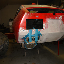

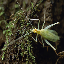

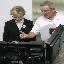

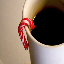

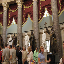

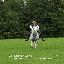

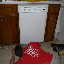

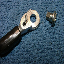

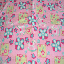

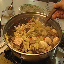

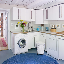

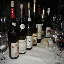

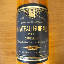

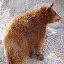

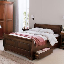

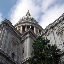

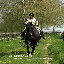

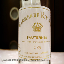

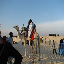

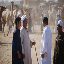

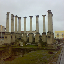

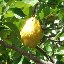

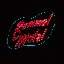

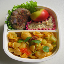

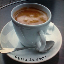

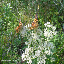

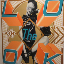

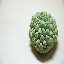

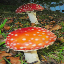

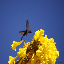

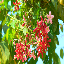

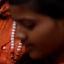

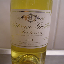

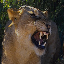

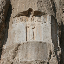

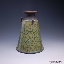

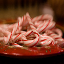

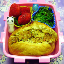

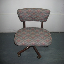

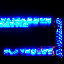

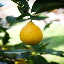

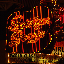

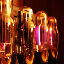

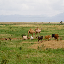

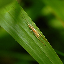

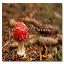

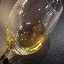

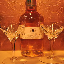

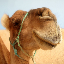

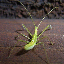

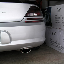

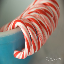

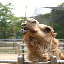

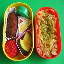

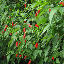

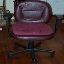

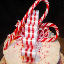

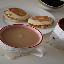

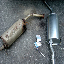

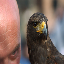

In [126]:
for idx in pred_idx:
    display(test_imgs[idx])

# Labelling the rest of the training data
Labelling all data from 9000-12000 using the prue face classifier

In [88]:
TRAIN_PATH = Path("../downloads/data_bb1/train")
assert TRAIN_PATH.exists()

train_img_paths = list(TRAIN_PATH.glob("TRAIN*.png"))
# find all images with names in the 9000s and 10000s
imgs_to_label = [path for path in train_img_paths if int(path.stem.split("N")[1]) in range(9000, 14000)]

print(f"number of images to label: {len(imgs_to_label)}")


label_imgs = [tf.keras.preprocessing.image.load_img(path, target_size=IMG_SIZE) for path in imgs_to_label]
label_array = np.array([tf.keras.preprocessing.image.img_to_array(img) for img in label_imgs])

number of images to label: 3284


In [89]:
label_preds = model.predict(label_array)

In [93]:
np.where(label_preds > 0)[0].shape

(1217,)

In [96]:
import shutil
from tqdm import tqdm

# make directories for faces and no faces
(TRAIN_PATH / "face").mkdir(exist_ok=True)
(TRAIN_PATH / "no_face").mkdir(exist_ok=True)

# copy images to appropriate directory
face_imgs = [imgs_to_label[i] for i in np.where(label_preds > 0)[0]]
for img in tqdm(face_imgs):
    shutil.copy(img, TRAIN_PATH / "no_face")

no_face_imgs = [imgs_to_label[i] for i in np.where(label_preds < 0)[0]]
for img in tqdm(no_face_imgs):
    shutil.copy(img, TRAIN_PATH / "face")

100%|██████████| 2067/2067 [00:11<00:00, 183.25it/s]


In [97]:
face_paths = list((TRAIN_PATH / "face").glob("*.png"))
no_face_paths = list((TRAIN_PATH / "no_face").glob("*.png"))

newdf = pd.DataFrame({"name": [path.name for path in face_paths + no_face_paths], "real_face": [1]*len(face_paths) + [0]*len(no_face_paths)})

In [111]:
labeldf = pd.read_csv("train/labels.csv")

new_labels = labeldf.merge(newdf, on="name", how="left")
new_labels["real_face"] = new_labels["real_face_x"].combine_first(new_labels["real_face_y"])
new_labels["real_face"] = pd.to_numeric(new_labels["real_face"], errors="coerce")
# convert larger than 1 to nan
new_labels["real_face"] = new_labels["real_face"].apply(lambda x: np.nan if x > 1 else x)

new_labels.drop(columns=["real_face_x", "real_face_y"]).to_csv("train/labels.csv", index=False)

In [110]:
new_labels.columns

Index(['name', 'skin_tone', 'gender', 'age', 'real_face_x', 'real_face_y',
       'real_face'],
      dtype='object')